# Convolutional Network

## Load CIFAR

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
from tqdm.notebook import tqdm
%matplotlib inline


In [54]:
BATCH_SIZE = 8
NUM_WORKERS = 4
LOG_DIR = 'runs'

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=NUM_WORKERS)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=NUM_WORKERS)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


car cat deer frog plane dog plane plane
Wall time: 5.98 s


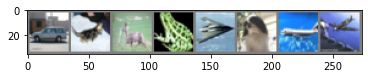

In [55]:
%%time
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img * .5 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[j]}' for j in labels))

Distribution of images per label:

In [12]:
[print(f'{c} \t {trainset.targets.count(j)}') for j, c in enumerate(classes)];

plane 	 5000
car 	 5000
bird 	 5000
cat 	 5000
deer 	 5000
dog 	 5000
frog 	 5000
horse 	 5000
ship 	 5000
truck 	 5000


## Convolutional layers

We'll use Adam optimizer for training

In [80]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


device = "cuda" if torch.cuda.is_available() else "cpu"

def initialize_net(cnn, lr=0.001, device='cpu', seed=42):
    torch.manual_seed(seed)
    if device == 'cuda':
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        
    net = cnn().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=lr)
    
    return net, criterion, optimizer


In [81]:
class CNN(nn.Module):
    def __init__(self, 
                 out_conv1=32, 
                 out_conv2=64, 
                 out_conv3=128, 
                 out_fc1=256, 
                 out_fc2=128):
        
        super(CNN, self).__init__()
        
        self.out_conv1 = out_conv1
        self.out_conv2 = out_conv2
        self.out_conv3 = out_conv3
        
        self.out_fc1 = out_fc1
        self.out_fc2 = out_fc2
        
        self.conv1 = nn.Conv2d(in_channels=3, 
                               out_channels=self.out_conv1, 
                               kernel_size=3, 
                               padding=1)
        
        self.conv2 = nn.Conv2d(in_channels=self.out_conv1, 
                               out_channels=self.out_conv2, 
                               kernel_size=3, 
                               padding=1)
        
        self.conv3 = nn.Conv2d(in_channels=self.out_conv2, 
                               out_channels=self.out_conv3, 
                               kernel_size=3, 
                               padding=1)
        
        self.fc1 = nn.Linear(in_features=self.out_conv3 * 4 * 4, 
                             out_features=self.out_fc1)  

        self.fc2 = nn.Linear(in_features=self.out_fc1, 
                             out_features=self.out_fc2)
        
        self.fc3 = nn.Linear(in_features=self.out_fc2, 
                             out_features=10)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = F.relu
        
        
    def forward(self, x):
        
        self.activation = self.conv1(x)
        out = self.pool(self.relu(self.activation))
        out = self.pool(self.relu(self.conv2(out)))
        out = self.pool(self.relu(self.conv3(out)))
        
        out = out.view(out.shape[0], -1)
        
        out = self.relu(self.fc1(out))
        out = self.relu(self.fc2(out))
        out = self.fc3(out)
        
        return out
        

### Network summary

In [91]:
channels=3; H=32; W=32
from torchsummary import summary
summary(small_net, input_size=(channels, H, W))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
         MaxPool2d-2           [-1, 32, 16, 16]               0
            Conv2d-3           [-1, 64, 16, 16]          18,496
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5            [-1, 128, 8, 8]          73,856
         MaxPool2d-6            [-1, 128, 4, 4]               0
            Linear-7                  [-1, 256]         524,544
            Linear-8                  [-1, 128]          32,896
            Linear-9                   [-1, 10]           1,290
Total params: 651,978
Trainable params: 651,978
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.55
Params size (MB): 2.49
Estimated Total Size (MB): 3.05
-------------------------------------------

### Small network
We'll start with a small overfitted network to verify that it works

In [83]:
%%time
small_net, criterion, optimizer = initialize_net(CNN, device=device)

dataiter = iter(testloader)
n_batches = 25
n_epochs = 40
x, y = [], []

for _ in range(n_batches):
    images, labels = dataiter.next()
    x.append(images)
    y.append(labels)

Wall time: 3.86 s


In [84]:
%%time
print('\nStarted Training\n')

for epoch in tqdm(range(n_epochs)):
    running_accuracy = 0.
    running_loss = 0.
    for i in range(n_batches):
        xi, yi = x[i].to(device), y[i].to(device)
        optimizer.zero_grad()
        outputs = small_net(xi)
        loss = criterion(outputs, yi)
        loss.backward()
        optimizer.step()
        _, predictions = torch.max(outputs, 1)
        accuracy = (yi == predictions.squeeze()).float().mean()
        running_accuracy += accuracy.item()
        running_loss += loss.item()


    print(f'epoch: {epoch + 1}\t loss:{running_loss / n_batches:.3f}\t acc:{running_accuracy / n_batches:.2f}')

print('\nFinished Training')


Started Training



  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 1	 loss:2.305	 acc:0.14
epoch: 2	 loss:2.197	 acc:0.25
epoch: 3	 loss:2.061	 acc:0.25
epoch: 4	 loss:1.990	 acc:0.28
epoch: 5	 loss:1.907	 acc:0.29
epoch: 6	 loss:1.873	 acc:0.33
epoch: 7	 loss:1.864	 acc:0.36
epoch: 8	 loss:1.762	 acc:0.39
epoch: 9	 loss:1.537	 acc:0.47
epoch: 10	 loss:1.367	 acc:0.53
epoch: 11	 loss:1.148	 acc:0.63
epoch: 12	 loss:1.045	 acc:0.66
epoch: 13	 loss:1.087	 acc:0.67
epoch: 14	 loss:0.865	 acc:0.72
epoch: 15	 loss:0.759	 acc:0.74
epoch: 16	 loss:0.607	 acc:0.77
epoch: 17	 loss:0.515	 acc:0.83
epoch: 18	 loss:0.338	 acc:0.88
epoch: 19	 loss:0.286	 acc:0.90
epoch: 20	 loss:0.258	 acc:0.94
epoch: 21	 loss:0.118	 acc:0.96
epoch: 22	 loss:0.095	 acc:0.97
epoch: 23	 loss:0.083	 acc:0.98
epoch: 24	 loss:0.043	 acc:0.98
epoch: 25	 loss:0.016	 acc:1.00
epoch: 26	 loss:0.008	 acc:1.00
epoch: 27	 loss:0.004	 acc:1.00
epoch: 28	 loss:0.002	 acc:1.00
epoch: 29	 loss:0.002	 acc:1.00
epoch: 30	 loss:0.001	 acc:1.00
epoch: 31	 loss:0.001	 acc:1.00
epoch: 32	 loss:0

In [60]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

GroundTruth:  cat ship ship plane frog frog car frog
Predicted:    cat ship ship plane frog frog car frog
Wall time: 3.83 s


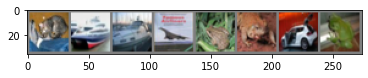

In [85]:
%%time
dataiter = iter(testloader)
images, labels = dataiter.next()
outputs = small_net(images.to(device))
_, predicted = torch.max(outputs, 1)

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[j]}' for j in labels))
print('Predicted:   ', ' '.join(f'{classes[j]}' for j in predicted))

In [95]:
def evaluate_net(net, loader):

    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))

    with torch.no_grad():
        for data in tqdm(loader):
            images, labels = data
            outputs = net(images.to(device))
            _, predicted = torch.max(outputs.data, 1)
            c = (predicted == labels.to(device)).squeeze()

            for i in range(BATCH_SIZE):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    [print(f'Accuracy of {c}: \t {100 * class_correct[j] / class_total[j]}%') 
     for j, c in enumerate(classes)];

    print('\nAccuracy of the network on the 10000 test images:',  
          f'{100 * np.sum(class_correct) / np.sum(class_total)}%')



In [96]:
%%time
evaluate_net(small_net, testloader)

  0%|          | 0/1250 [00:00<?, ?it/s]

Accuracy of plane: 	 40.3%
Accuracy of car: 	 29.0%
Accuracy of bird: 	 23.3%
Accuracy of cat: 	 17.6%
Accuracy of deer: 	 17.0%
Accuracy of dog: 	 17.5%
Accuracy of frog: 	 42.8%
Accuracy of horse: 	 19.8%
Accuracy of ship: 	 47.6%
Accuracy of truck: 	 37.1%

Accuracy of the network on the 10000 test images: 29.2%
Wall time: 6.78 s


We got low accuracy for this simple network. Our small network is overfitting a small portion of the training set and the training loss is almost zero. <br>
Let's train the network on a bigger training set to improve the results.

### Train on a bigger training set

In [87]:
def train_nn(net, crit, opt, n_epochs=8, every_n_iter=1000, return_activation=True, loder=trainloader):
    step = 0
    print('\nStarted Training')
    
    for epoch in tqdm(range(n_epochs)):
        running_loss = 0.0
        running_accuracy = 0.0
        running_avg_weights = 0.0

        for i, train_data in enumerate(loder):
            inputs, labels = train_data[0].to(device), train_data[1].to(device) 
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, predictions = torch.max(outputs, 1)
            accuracy = (labels == predictions.squeeze()).float().mean()
            running_accuracy += accuracy.item()
            running_loss += loss.item()
            running_avg_weights += torch.mean(net.conv1.weight.data)

            if (i % every_n_iter) == (every_n_iter - 1):
                print(f'epoch: {epoch + 1}\t iter: {i + 1}\t loss:{running_loss / every_n_iter:.5f}\t acc:{running_accuracy / every_n_iter:.2f}')
                running_test_accuracy = 0.0
                net.eval()

                with torch.no_grad():
                    for test_data in testloader:
                        test_images, test_labels = test_data[0].to(device), test_data[1].to(device) 
                        test_outputs = net(test_images)
                        _, test_pred = torch.max(test_outputs, 1)
                        test_accuracy = (test_labels == test_pred.squeeze()).float().mean()
                        running_test_accuracy += test_accuracy.item()

                net.train()
                step += 1
                running_loss = 0.0
                running_accuracy = 0.0
                running_avg_weights = 0.0

    print('\nFinished Training\n')

In [73]:
%%time
main_net, criterion, optimizer = initialize_net(CNN, device=device)
train_nn(main_net, criterion, optimizer, n_epochs=2)
evaluate_net(main_net, testloader)


Started Training


  0%|          | 0/2 [00:00<?, ?it/s]

epoch: 1	 iter: 1000	 loss:1.84751	 acc:0.31
epoch: 1	 iter: 2000	 loss:1.49630	 acc:0.45
epoch: 1	 iter: 3000	 loss:1.33675	 acc:0.51
epoch: 1	 iter: 4000	 loss:1.24837	 acc:0.55
epoch: 1	 iter: 5000	 loss:1.18466	 acc:0.57
epoch: 1	 iter: 6000	 loss:1.11496	 acc:0.60
epoch: 2	 iter: 1000	 loss:1.01400	 acc:0.64
epoch: 2	 iter: 2000	 loss:0.97258	 acc:0.66
epoch: 2	 iter: 3000	 loss:0.95730	 acc:0.66
epoch: 2	 iter: 4000	 loss:0.93746	 acc:0.67
epoch: 2	 iter: 5000	 loss:0.90628	 acc:0.68
epoch: 2	 iter: 6000	 loss:0.87359	 acc:0.69

Finished Training

Accuracy of plane: 	 76.1%
Accuracy of car: 	 72.9%
Accuracy of bird: 	 61.2%
Accuracy of cat: 	 60.3%
Accuracy of deer: 	 63.1%
Accuracy of dog: 	 37.8%
Accuracy of frog: 	 75.8%
Accuracy of horse: 	 74.8%
Accuracy of ship: 	 85.0%
Accuracy of truck: 	 81.0%

Accuracy of the network on the 10000 test images: 68.8%
Wall time: 3min 48s


We can see that trining on a bigger set resulted in a higher accuracy than before. 

## Batch Normalization

In [47]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class BatchNormNet(nn.Module):
    def __init__(self, 
                 out_conv1=32, 
                 out_conv2=64, 
                 out_conv3=128, 
                 out_fc1=256, 
                 out_fc2=128):
        
        super(BatchNormNet, self).__init__()
        
        self.out_conv1 = out_conv1
        self.out_conv2 = out_conv2
        self.out_conv3 = out_conv3
        self.out_fc1 = out_fc1
        self.out_fc2 = out_fc2
        self.conv1 = nn.Conv2d(in_channels=3, 
                               out_channels=self.out_conv1, 
                               kernel_size=3, 
                               padding=1)
        
        self.conv1_bn = nn.BatchNorm2d(self.out_conv1)
        
        self.conv2 = nn.Conv2d(in_channels=self.out_conv1, 
                               out_channels=self.out_conv2, 
                               kernel_size=3, 
                               padding=1)
        
        self.conv2_bn = nn.BatchNorm2d(self.out_conv2)
        
        self.conv3 = nn.Conv2d(in_channels=self.out_conv2, 
                               out_channels=self.out_conv3, 
                               kernel_size=3, 
                               padding=1)
        
        self.conv3_bn = nn.BatchNorm2d(self.out_conv3)
        
        self.fc1 = nn.Linear(in_features=self.out_conv3 * 4 * 4, 
                             out_features=self.out_fc1)  
        self.fc1_bn = nn.BatchNorm1d(self.out_fc1)
        
        self.fc2 = nn.Linear(in_features=self.out_fc1, 
                             out_features=self.out_fc2)
        
        self.fc2_bn = nn.BatchNorm1d(self.out_fc2)
        
        self.fc3 = nn.Linear(in_features=self.out_fc2, 
                             out_features=10)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = F.relu
        
    def forward(self, x):
        self.activation = self.conv1_bn(self.conv1(x))
        out = self.pool(self.relu(self.activation))
        out = self.pool(self.relu(self.conv2_bn(self.conv2(out))))
        out = self.pool(self.relu(self.conv3_bn(self.conv3(out))))
        out = out.view(out.shape[0], -1)
        out = self.relu(self.fc1_bn(self.fc1(out)))
        out = self.relu(self.fc2_bn(self.fc2(out)))
        out = self.fc3(out)
        
        return out
        

In [72]:
net_bn, criterion, optimizer = initialize_net(BatchNormNet, device=device)

### Network summary

In [70]:
channels=3; H=32; W=32
from torchsummary import summary
summary(net_bn, input_size=(channels, H, W))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
         MaxPool2d-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 64, 16, 16]          18,496
       BatchNorm2d-5           [-1, 64, 16, 16]             128
         MaxPool2d-6             [-1, 64, 8, 8]               0
            Conv2d-7            [-1, 128, 8, 8]          73,856
       BatchNorm2d-8            [-1, 128, 8, 8]             256
         MaxPool2d-9            [-1, 128, 4, 4]               0
           Linear-10                  [-1, 256]         524,544
      BatchNorm1d-11                  [-1, 256]             512
           Linear-12                  [-1, 128]          32,896
      BatchNorm1d-13                  [-1, 128]             256
           Linear-14                   

### Train and evaluate

In [71]:
train_nn(net_bn, criterion, optimizer, n_epochs=2)
evaluate_net(net_bn, testloader)


Started Training


  0%|          | 0/2 [00:00<?, ?it/s]

epoch: 1	 iter: 1000	 loss:1.70741	 acc:0.38
epoch: 1	 iter: 2000	 loss:1.39316	 acc:0.51
epoch: 1	 iter: 3000	 loss:1.30911	 acc:0.54
epoch: 1	 iter: 4000	 loss:1.23235	 acc:0.57
epoch: 1	 iter: 5000	 loss:1.16997	 acc:0.59
epoch: 1	 iter: 6000	 loss:1.09847	 acc:0.62
epoch: 2	 iter: 1000	 loss:1.02964	 acc:0.65
epoch: 2	 iter: 2000	 loss:0.99472	 acc:0.66
epoch: 2	 iter: 3000	 loss:0.98521	 acc:0.66
epoch: 2	 iter: 4000	 loss:0.94983	 acc:0.67
epoch: 2	 iter: 5000	 loss:0.94302	 acc:0.67
epoch: 2	 iter: 6000	 loss:0.91693	 acc:0.69

Finished Training

Accuracy of plane: 	 71.1%
Accuracy of car: 	 78.6%
Accuracy of bird: 	 45.3%
Accuracy of cat: 	 49.3%
Accuracy of deer: 	 70.4%
Accuracy of dog: 	 59.7%
Accuracy of frog: 	 72.5%
Accuracy of horse: 	 73.2%
Accuracy of ship: 	 79.0%
Accuracy of truck: 	 83.3%

Accuracy of the network on the 10000 test images: 68.24%


The loss and acc of the model with the batch normalization layers are worse than before applying the batch. However Batch normalization can help to reduce overfitting and enhance performance of the CNN.